# Vision Transformerを用いた自己教師あり学習のpatch同士の意味

※このコードはデータセットを使用せずに、自分の好きな画像を入れるものである。データセットを使用したい場合は画像のところを好きなデータセットに変える。また、gpu環境で動かしているため、cpu環境だと動かない可能性がる。

vision transformerを用いたDINOというモデルを使用する。<br>
DINOとは旧facebook社が公開している自己教師あり学習のモデルである。

In [1]:
import torch
vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
vits8 = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
vitb16 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
vitb8 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')
xcit_small_12_p16 = torch.hub.load('facebookresearch/dino:main', 'dino_xcit_small_12_p16')
xcit_small_12_p8 = torch.hub.load('facebookresearch/dino:main', 'dino_xcit_small_12_p8')
xcit_medium_24_p16 = torch.hub.load('facebookresearch/dino:main', 'dino_xcit_medium_24_p16')
xcit_medium_24_p8 = torch.hub.load('facebookresearch/dino:main', 'dino_xcit_medium_24_p8')
resnet50 = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')

Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_xcit_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_xcit_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_xcit_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_dino_main
Using cache found in /home/yishido/.cache/torch/hub/facebookresearch_xcit_main
Using cache found in /home/yishido/.cache/torch/hub/

その中で今回はvitb16(patchsize=16)を使用する

In [2]:
model = vitb16

## 1.　patchの意味の確認
vision transformerの最終層のpatch(分割した小さな画像)の表現に意味があるのか、確認する

画像の正規化

In [16]:
from PIL import Image
import torchvision
import torchvision.transforms as transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406] #imagenetの正規化
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGENET_SIZE = 224

transform = transforms.Compose([
                transforms.Resize(256, interpolation=3),
                transforms.CenterCrop(IMAGENET_SIZE),
                transforms.ToTensor(),
                transforms.Normalize((IMAGENET_MEAN), (IMAGENET_STD)),
                ])

/home/yishido/.pyenv/versions/3.8.10/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


今回は猫と犬の画像を使用する。Vision Transformerの最終層のpatchの表現に対応するように、画像を分割する。

In [23]:
image = Image.open("./犬と猫.jpeg")
image = transform(image).to("cuda")

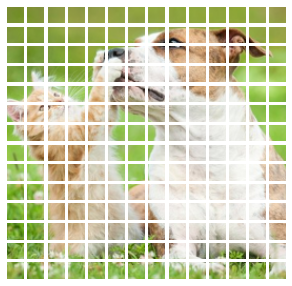

In [24]:
import numpy as np
import matplotlib.pyplot as plt

#正規化解除
img_1 = image.to("cpu").mul(torch.FloatTensor(IMAGENET_STD).view(3, 1, 1))
img_2 = img_1.add(torch.FloatTensor(IMAGENET_MEAN).view(3, 1, 1)).detach().numpy()
img = np.transpose(img_2, (1, 2, 0))

rows = 224/16  # 行数 
cols = 224/16  # 列数

#patchサイズ１６の形に分割
chunks = []
for row_img in np.array_split(img, rows, axis=0):
    for chunk in np.array_split(row_img, cols, axis=1):
        chunks.append(chunk)
        
#表示        
plt.figure(figsize=(5,5))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(len(chunks)):
    plt.subplot(14, 14, i+1)
    plt.imshow(chunks[i])
    plt.axis('off')
plt.show()

vit16は、パッチの大きさが16×16のもの。つまり、224×224の画像は224÷16でパッチの数が14×14個になる。<br>
次に、この１つずつのpatchに対応する表現を、学習済みモデルのvision transformerの最終層から表現を抽出する。

In [21]:
def extract(target, inputs):#抽出する関数
    feature = None

    def forward_hook(module, inputs, outputs):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    net.eval()
    net(inputs)

    # コールバック関数を解除する。
    handle.remove()

    return features

In [29]:
net = vitb16.to("cuda")
target_module = net.norm
emb = extract(target_module, image.unsqueeze(0)) #batch_sizeの次元がない為、追加する。データセットを使う場合は"unsqueeze(0)"はいらない

patchの画像と表現を結びつけ、TSNEで表現を二次元に落とし込み、可視化させる。

/home/yishido/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yishido/.pyenv/versions/3.8.10/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


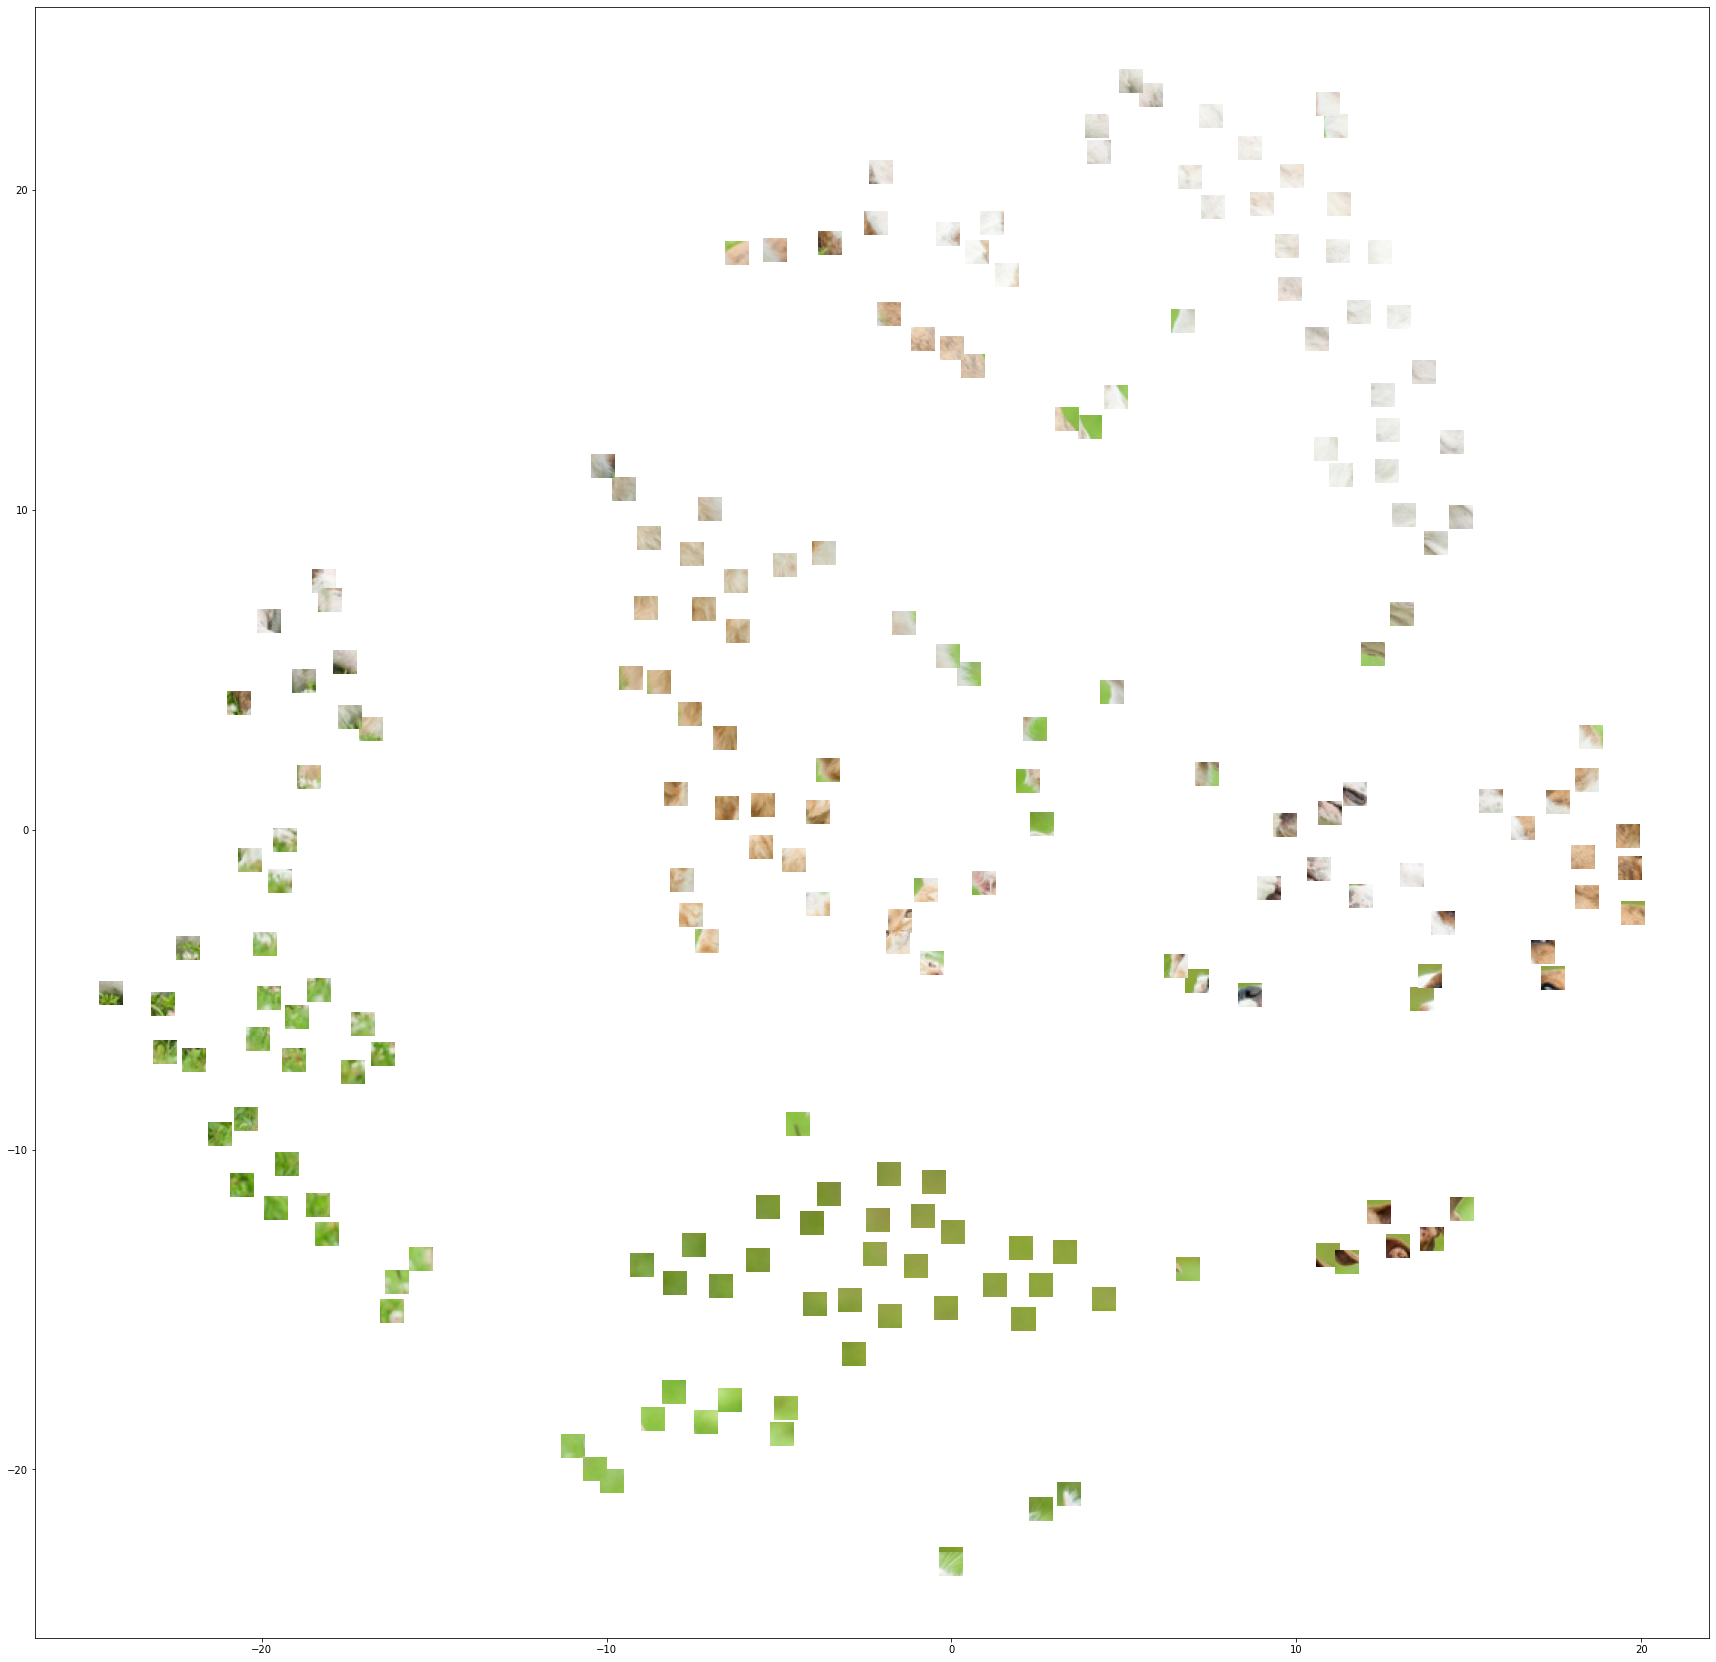

In [32]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


tsne = TSNE(n_components=2, random_state = 0, perplexity = 20, n_iter = 1000)
X_embedded = tsne.fit_transform(emb[0].to("cpu"))

def imscatter(x, y, image_list, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    im_list = [OffsetImage(image_list[p], zoom=zoom) for p in range(len(image_list))]
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, im in zip(x, y, im_list):#
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

# perplexity: 20
fig, ax = plt.subplots(figsize=(30,30))
imscatter(X_embedded[1:,0], X_embedded[1:,1], chunks, ax=ax, zoom=1.5) #visiontransformerは最初に変なのつくからのぞく

# plt.savefig("tsne_patch")
plt.show()

似ている画像のpatchは表現が近いことがわかる。<br>
このことから、vision transformerのpatchの表現に意味があるのだとわかる。

## 2. Vision Transformerの注目点を確認

rolloutを使って、vision transformerのattentionから注目点を可視化する。

In [39]:
import argparse
import sys
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import cv2

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout

attention_rollout = VITAttentionRollout(model, head_fusion='max', 
    discard_ratio=0.9)
mask = attention_rollout(image.unsqueeze(0))
name = "attention_rollout_{:.3f}_{}.png".format(0.9, 'max')

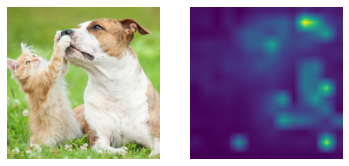

In [40]:
mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

plt.figure()

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask)

plt.axis('off')
#plt.savefig("dino")
plt.show()

この画像では猫ではなく犬に注目していることがわかる。

## 3. 画像のどことどこに注目しているのか確認する。

自己教師あり学習では２枚の画像を近づけるため、その際に画像のどことどこが似ているのか、自己教師ありで学習させたvision transformerの最終層からpatchの表現を抽出し、お互いの画像のpatchの表現同士の内積を比べることで確認する。

In [41]:
def dot_sim(v1, v2):#内積の関数
    return torch.dot(v1, v2)

内積の結果を画像で表示させる関数

In [44]:
import torch, torchvision, einops
import numpy as np
from typing import Any, BinaryIO, List, Optional, Tuple, Union
import matplotlib.pyplot as plt
import matplotlib, functools, datetime, os



def imshow(img: Any, 
            mask: Any = None,
            nrow: Union[int,None] = None, 
            padding: int = 2, 
            normalize: Union[str, Tuple[int, int]] = "std", 
            scale_each: bool = False, 
            pad_value: float = 0, 
            require_return: bool = False,
            save_name: str = None,
            **kwargs: Any):

    def prepro(img, var_name):
        # ndarray -> tensor
        if  type(img) is np.ndarray:
            img = torch.Tensor(img)

        #type check
        if type(img) is not torch.Tensor:
            TypeError(f"{var_name} : type {type(img)} is not supported.")

        # detaches, moves to cpu, and requires no grad
        img = img.detach().cpu().requires_grad_(False)

        #convert to float
        img = img.to(torch.float)

        # dimension check
        switched_row_col = None
        if len(img.shape) == 2:
            nrow = 1
            img = einops.rearrange(img, "h w -> 1 1 h w")
        elif len(img.shape) == 3:
            nrow = 1
            img = einops.rearrange(img, "c h w -> 1 c h w")
        elif len(img.shape) == 5:
            b, t, _, _, _ = img.shape
            nrow = max(b, t)
            if t < b:
                switched_row_col = True
                img = einops.rearrange(img, "b t c h w -> (t b) c h w")
            else:
                switched_row_col = False
                img = einops.rearrange(img, "b t c h w -> (b t) c h w")
        else:
            nrow = round(img.size(0) ** 0.5)
        if len(img.shape) != 4:
            raise ValueError(f"{var_name} : {img.shape} but needs to have either 3 or 4 dim.")

        #print(var_name, img.shape)
        # channel auto select
        b, c1, h, c2 = img.shape
        if c1 > c2:
            img = einops.rearrange(img, "b h w c -> b c h w")

        #print(var_name, img.shape)
        # channel size check
        c = min(c1, c2)
        if c > 3:
            raise ValueError(f"{var_name} : (b, c1, h, c2) = {img.shape} but c1 or c2 should be <= 3.")
        elif c == 2:
            img = torch.nn.functional.pad(img, (0,0,0,0,0,1)) # use only RG
        elif c ==  1:
            img = einops.repeat(img, "b c h w -> b (n c) h w", n=3)
            # to RBG
        
        return img, (nrow, switched_row_col)
    
    img, (_nrow, switched_row_col) = prepro(img, "img")

    if nrow is None:
        nrow = _nrow

    if scale_each:
        stats = { op : einops.reduce(img, "b c h w -> b () () ()", op)
                 for op in ("min","max","mean") }
        std = torch.std(img, dim=(1,2,3), keepdim=True) 
    else:
        stats = { op : einops.reduce(img, "b c h w -> () () () ()", op)
                 for op in ("min","max","mean") } 
        std = torch.std(img) 

    if type(normalize) is str:
        if normalize.lower() == "none":
            a = 0
            b = 1
        elif "minmax" in normalize.lower():
            a = stats["min"]
            b = stats["max"]
            a, b = a.item(), b.item()
        elif "std" in normalize.lower():
            a = stats["mean"] - 2 * std
            b = stats["mean"] + 2 * std
            a, b = a.item(), b.item()
    else:
        a,b = tuple(normalize)
        if a > b:
            raise ValueError(f"normalize = {normalize} but it is requried that a < b.")

    img = (img - a) / (b - a + 1e-6)
        

    print(f"min:{a} max:{b}")
    # Anyway clamp to [0, 1].
    img = torch.clamp(img, 0, 1)

    # If mask exists...
    if mask is not None:
        mask, _ = prepro(mask, "mask")
        img *= mask

    img = torchvision.utils.make_grid(img, nrow = nrow, 
                                padding = padding, 
                                normalize = False, 
                                value_range = None, 
                                scale_each = False, 
                                pad_value = pad_value,  *kwargs)
    img = img.permute(1,2,0)

    dpi = matplotlib.rcParams['figure.dpi']/10 #################
    figsize = img.size(1) / float(dpi), img.size(0) / float(dpi)
    figsize = min(10, figsize[0]), min(10, figsize[1])
    # plt.rcParams["image.cmap"] = "jet" 
    plt.figure(figsize=figsize)

    if switched_row_col is not None:
        labels = ["First Axis", "Second Axis"]
        if switched_row_col:
            labels = labels[::-1]
        plt.ylabel(labels[0])
        plt.xlabel(labels[1])
    plt.imshow(img,  *kwargs)
    plt.axis('off')
    
    if save_name is not None:
        plt.savefig(f"{save_name}")
    
    plt.show()

    if require_return:
        return img 

比べる２枚の画像

In [50]:
img1 = Image.open("./犬と猫.jpeg")
img2 = Image.open("./猫.jpg")

img1 = transform(img1).to("cuda")
img2 = transform(img2).to("cuda")

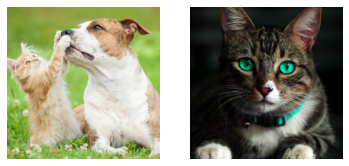

In [51]:
image1 = img1.to("cpu").mul(torch.FloatTensor(IMAGENET_STD).view(3, 1, 1))
image1 = image1.add(torch.FloatTensor(IMAGENET_MEAN).view(3, 1, 1)).detach().numpy()
image2 = img2.to("cpu").mul(torch.FloatTensor(IMAGENET_STD).view(3, 1, 1))
image2 = image2.add(torch.FloatTensor(IMAGENET_MEAN).view(3, 1, 1)).detach().numpy()

plt.figure()

plt.subplot(1,2,1)
plt.imshow(np.transpose(image1, (1, 2, 0)))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.transpose(image2, (1, 2, 0)))

plt.axis('off')
#plt.savefig("dino")
plt.show()

内積の計算

In [46]:
target_module = model.norm
sim1 = []
sim2 = []

emb1 = extract(target_module, img1.unsqueeze(0))[0][1:,]# とりあえずclsはのぞく
emb2 = extract(target_module, img2.unsqueeze(0))[0][1:,]

for i in range(len(emb1)):
    for j in range(len(emb2)):
        sim1.append(dot_sim(emb1[i], emb2[j]))

for i in range(len(emb2)):
    for j in range(len(emb1)):
        sim2.append(dot_sim(emb2[i], emb1[j]))

min:182.9521484375 max:1286.780029296875


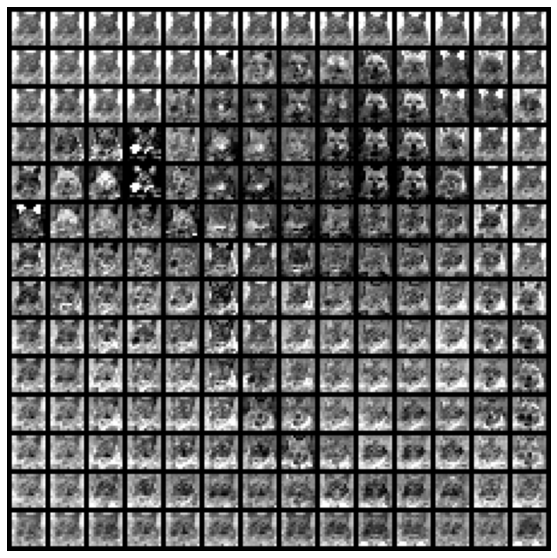

In [47]:
y = torch.stack(sim1).reshape(14,14,1,14,14)
imshow(y)

左の画像(猫と犬)が、右の画像(猫)とどこが似ているのか内積の結果を可視化したもの。大きな正方形が左の画像であり、小さな画像が右の画像である。内積の結果が高いと白く、低いと黒く現れる。

min:182.9521484375 max:1286.780029296875


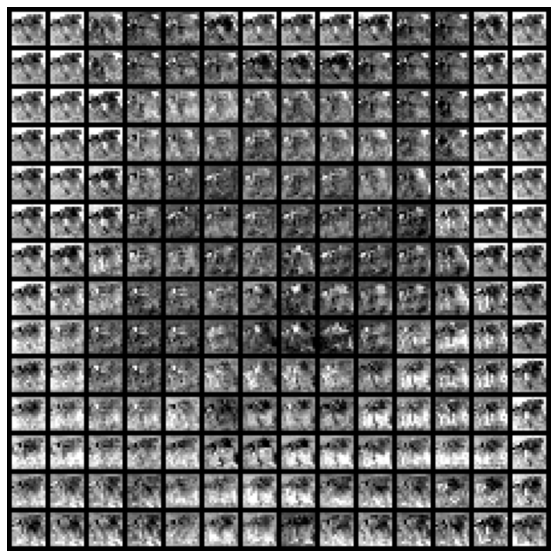

In [52]:
y = torch.stack(sim2).reshape(14,14,1,14,14)
imshow(y)

小さな画像と大きな画像を入れ替えたもの。大きな画像が右の画像(猫)で、小さな画像左の画像(猫と犬)を表す。<br>

このことから自己教師あり学習では、物体と背景は区別できるが、猫と犬といったように細かいもの同士の表現は分かれていないことが考えられる。